In [1]:
import sys
from pathlib import Path

# 当前工作目录：.../quant-a-share/quant-a-share/notebooks
print("CWD =", Path.cwd())

# 项目根目录 = notebooks 的上一级
PROJECT_ROOT = Path.cwd().parent
print("PROJECT_ROOT =", PROJECT_ROOT)

# 把项目根目录塞进 sys.path，才能 import quant_system
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("quant_system 是否存在：", (PROJECT_ROOT / "quant_system").exists())
print("PROJECT_ROOT 是否已在 sys.path:", str(PROJECT_ROOT) in sys.path)


CWD = e:\Lianghuagit\quant-a-share\quant-a-share\notebooks
PROJECT_ROOT = e:\Lianghuagit\quant-a-share\quant-a-share
quant_system 是否存在： True
PROJECT_ROOT 是否已在 sys.path: True


In [2]:
from quant_system.data.storage import DB_PATH, get_db_connection

print("DB_PATH from storage.py =", DB_PATH)

conn = get_db_connection()
cur = conn.execute("SELECT name FROM sqlite_master WHERE type='table'")
tables = [row[0] for row in cur.fetchall()]
conn.close()

print("tables:", tables)


[storage] BASE_DIR = E:\Lianghuagit\quant-a-share\quant-a-share
[storage] DB_PATH  = E:\Lianghuagit\quant-a-share\quant-a-share\data_cache\market_data.sqlite
DB_PATH from storage.py = E:\Lianghuagit\quant-a-share\quant-a-share\data_cache\market_data.sqlite
tables: ['stock_info', 'stock_daily', 'index_daily', 'stock_industry']


In [3]:
from quant_system.data.storage import load_stock_daily

df = load_stock_daily(["sh.688192"], "2025-01-01", "2025-12-31")
print("shape =", df.shape)
print(df.head())
print(df.tail())


shape = (225, 8)
                       open   high    low  close  preclose     volume  \
trade_date code                                                         
2025-01-02 sh.688192  41.41  42.00  40.12  41.16     41.47  2353550.0   
2025-01-03 sh.688192  41.14  41.77  39.15  40.00     41.16  2717860.0   
2025-01-06 sh.688192  39.88  40.30  38.15  38.83     40.00  2255004.0   
2025-01-07 sh.688192  38.73  39.21  37.58  37.73     38.83  1886511.0   
2025-01-08 sh.688192  37.80  40.20  37.73  38.21     37.73  3139217.0   

                            amount  pct_chg  
trade_date code                              
2025-01-02 sh.688192  9.665356e+07  -0.7475  
2025-01-03 sh.688192  1.094893e+08  -2.8183  
2025-01-06 sh.688192  8.791460e+07  -2.9250  
2025-01-07 sh.688192  7.187040e+07  -2.8329  
2025-01-08 sh.688192  1.219282e+08   1.2722  
                       open   high    low  close  preclose     volume  \
trade_date code                                                         
202

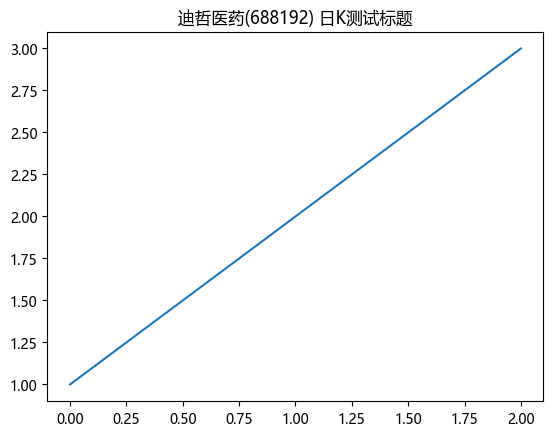

In [4]:
import matplotlib as mpl
from matplotlib import font_manager
import matplotlib.pyplot as plt

# 1. 把 Windows 里的字体文件手动加入 Matplotlib
font_path = r"C:\Windows\Fonts\msyh.ttc"   # 微软雅黑，你机器上肯定有
font_manager.fontManager.addfont(font_path)

# 2. 告诉 Matplotlib：以后无衬线字体就用它
mpl.rcParams["font.sans-serif"] = ["Microsoft YaHei"]

# 3. 解决坐标轴负号的方块问题
mpl.rcParams["axes.unicode_minus"] = False

# 4. 简单自测一张图
plt.figure()
plt.title("迪哲医药(688192) 日K测试标题")
plt.plot([1, 2, 3])
plt.show()


In [8]:
import mplfinance as mpf
import matplotlib as mpl
import pandas as pd

# 基于 "yahoo" 样式，复制一份，然后只改字体相关 rc 参数
style_zh = mpf.make_mpf_style(
    base_mpf_style="yahoo",
    rc={
        "font.family": "Microsoft YaHei",   # 和上一个 cell 里的字体保持一致
        "font.sans-serif": ["Microsoft YaHei"],
        "axes.unicode_minus": False,
    },
)


In [12]:
import datetime as dt
import pandas as pd
import mplfinance as mpf

from quant_system.data.storage import load_stock_daily

# 这里假定你前面已经定义好了 style_zh（基于 yahoo 的中文样式）
# 如果是在同一个 Notebook 里，只要上面的 cell 已经跑过就行

def plot_kline_from_db(
    code: str,
    start_date: str,
    end_date: str | None = None,
) -> None:
    """从本地 SQLite 读取某只股票在指定区间的日线并画 K 线。"""

    # 结束日期默认到今天
    if end_date is None:
        end_date = dt.date.today().strftime("%Y-%m-%d")

    # 1. 从 stock_daily 读数据
    df = load_stock_daily([code], start_date, end_date)

    if df is None or df.empty:
        print(f"⚠ 数据库中没有查到 {code} 在 {start_date}~{end_date} 的记录。")
        return

    # 2. 把 trade_date 转成真正的 datetime，并作为索引（mplfinance 要求 DatetimeIndex）
    df = df.reset_index()                      # 原来 index 是 MultiIndex(trade_date, code)
    df["trade_date"] = pd.to_datetime(df["trade_date"])
    df = df.set_index("trade_date").sort_index()

    print("index type =", type(df.index), df.index.dtype)
    print(df.head())
    print("记录条数：", len(df))

    # 3. 准备 mplfinance 需要的列
    df_mpf = df[["open", "high", "low", "close", "volume"]].copy()
    df_mpf.columns = ["Open", "High", "Low", "Close", "Volume"]

    # 4. 画图（用你自定义的中文样式）
    mpf.plot(
        df_mpf,
        type="candle",
        volume=True,
        style=style_zh,  # ← 这里用的是你上面定义好的 style_zh
        title=f"迪哲医药(688192) {start_date} 至 {end_date} 日K（本地数据库）",
        ylabel="价格",
        ylabel_lower="成交量",
        tight_layout=True,
    )


index type = <class 'pandas.core.indexes.datetimes.DatetimeIndex'> datetime64[ns]
                 code   open   high    low  close  preclose     volume  \
trade_date                                                               
2025-01-02  sh.688192  41.41  42.00  40.12  41.16     41.47  2353550.0   
2025-01-03  sh.688192  41.14  41.77  39.15  40.00     41.16  2717860.0   
2025-01-06  sh.688192  39.88  40.30  38.15  38.83     40.00  2255004.0   
2025-01-07  sh.688192  38.73  39.21  37.58  37.73     38.83  1886511.0   
2025-01-08  sh.688192  37.80  40.20  37.73  38.21     37.73  3139217.0   

                  amount  pct_chg  
trade_date                         
2025-01-02  9.665356e+07  -0.7475  
2025-01-03  1.094893e+08  -2.8183  
2025-01-06  8.791460e+07  -2.9250  
2025-01-07  7.187040e+07  -2.8329  
2025-01-08  1.219282e+08   1.2722  
记录条数： 225


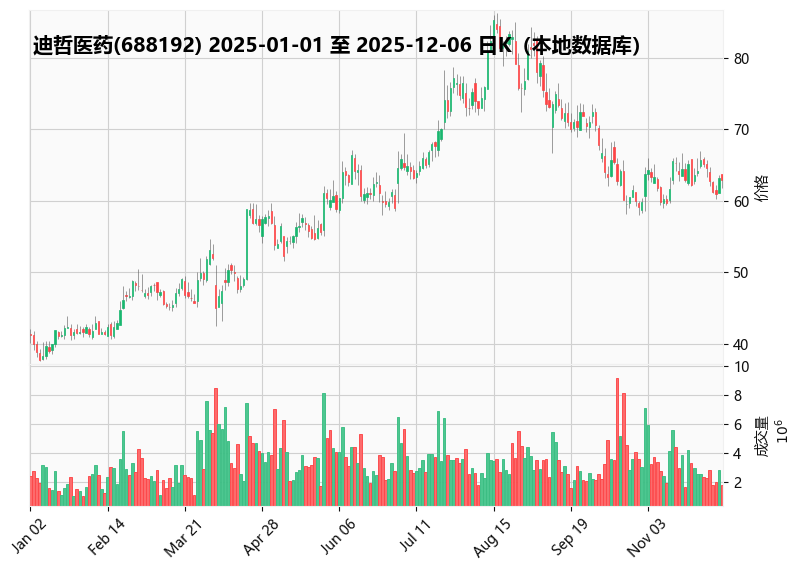

In [13]:
plot_kline_from_db("sh.688192", "2025-01-01")
